# Predict relevant Journal Articles

Included in the database is a list of journal articles from a number of journals, some of which are relevant to the Voth Group research areas, and most that are not relevant. Here we will use SVMs to predict the relevant articles.

In [1]:
import sqlite3
from time import time
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import logging

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')




## Load in Data from database

First, create connection with database. Then, pull out all journal article titles.

Note: Some of the journal articles are not actually "journal articles", so I have just remoeved them from the training data set.

In [2]:
db_file = 'test.db'
db_conn = sqlite3.connect(db_file)
c = db_conn.cursor()


article_titles = []
article_isRelevant = []
articles = []
results = c.execute('SELECT title, isVoth FROM Articles WHERE created_at < ?', ('2018-06-01 00:00:00',))
for title, isVoth in results:
    if 'Spotlights' not in title and 'Editorial' not in title and 'News at a glance' not in title:
        article_titles.append(title)
        article_isRelevant.append(isVoth)
        articles.append((title, isVoth))


data = pd.DataFrame.from_records(articles, columns=['title', 'isvoth'])

Split the data into test and training data sets. This is not actually necessary here, since I have added Cross Validation for the model.

In [3]:
train_X, test_X, train_y, test_y = train_test_split(
    article_titles, article_isRelevant, test_size=0.25, random_state=0)


## Weighting the different classes
In this case, we should be more willing to accept false positives rather than false negatives. I.e. there are likely more relevant articles that the Voth group should be reading, but have not read. Additionally, while looking through the literature, tt is more preferable to look at some extra articles that are not relevant, versus potentially missing out on an important journal article. Therefore, instead of weighting based on inverse frequency, I have increased the weight for relevant articles. 

In [4]:
#weight_is_relevant = 1
weight_is_relevant = 2*1/(np.sum(article_isRelevant)/ len(article_isRelevant))
weight_is_not_relevant = 1
weights = {0:weight_is_not_relevant, 1:weight_is_relevant}

## Fitting the Model
I built the model in a number of steps and therefore used `sklearn.pipeline.Pipeline` to run through the different steps.
* First, I used the bag-of-words approach to build the parameter set. The `CountVectorizer` function will build this matrix.
* Since we want to pick out the unique, important words in a journal title, I used the term-frequency times inverse document-frequency transformer
* Last, I used the stochastic gradient descent classifier to build a linear SVM.

Additionally, I used the `GridSearchCV` to identify the ideal parameters for the `SGDClassifier` using 3-fold cross validation.

In [5]:


clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', random_state=42,
                                           max_iter=1000, tol=None, class_weight=weights)),])

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': np.logspace(-10, -6, num=5),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (50,100,1000,2000),
    #'clf__n_iter': (10, 50, 80),
}



grid_search = GridSearchCV(clf, parameters, n_jobs=6, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in clf.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(article_titles, article_isRelevant)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06]),
 'clf__max_iter': (50, 100, 1000, 2000),
 'clf__penalty': ('l2', 'elasticnet')}
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed: 17.1min finished


done in 1126.626s

Best score: 0.993
Best parameters set:
	clf__alpha: 1e-09
	clf__max_iter: 2000
	clf__penalty: 'elasticnet'


In [6]:
predicted = grid_search.best_estimator_.predict(test_X)

print(metrics.classification_report(test_y, predicted,
    target_names=['is not relevant', 'is relevant']))
cnf_matrix = metrics.confusion_matrix(test_y, predicted)

                 precision    recall  f1-score   support

is not relevant       1.00      1.00      1.00     39052
    is relevant       0.84      1.00      0.91       137

    avg / total       1.00      1.00      1.00     39189



Let's take a look at some of the false positives to see if they make sense

In [7]:
print('#title')
num = 0
for i, val in enumerate(predicted):
    if val == 1 and test_y[i] != val and num < 15:
        print( test_X[i])
        num += 1

#title
An Average Solvent Electrostatic Configuration Protocol for QM/MM Free Energy Optimization: Implementation and Application to Rhodopsin Systems
Effects of Coarse Graining and Saturation of Hydrocarbon Chains on Structure and Dynamics of Simulated Lipid Molecules
Neural Network Based Prediction of Conformational Free Energies - A New Route toward Coarse-Grained Simulation Models
Acceleration of biomolecular kinetics in Gaussian accelerated molecular dynamics
Information entropy changes in chemical reactions
QM/MM Simulations with the Gaussian Electrostatic Model: A Density-based Polarizable Potential
Lipid membranes catalyse the fibril formation of the amyloid-β (1–42) peptide through lipid-fibril interactions that reinforce secondary pathways
Surface Orientation and Temperature Effects on the Interaction of Silicon with Water: Molecular Dynamics Simulations Using ReaxFF Reactive Force Field
Imaging the dynamics of ion–molecule reactions
Tuning the Continuum of Structural States 

Above, we can see that many of the papers are about molecular dynaimcs and coarse-grained simulations, as well as about proteins and membranes, all things that the Voth Group is interested in!

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Confusion Matrix

Below we can see how often our model correctly predicts whether an article is relevant or not. This model overestimates the articles that are relevant for the Voth Group, which is exactly what we wanted. Here, only 30 articles are mislabeled. Using inverse frequency for weights in the model reduces the error even further - only a handful of articles are mislabeled. But, as I noted above, we expect that the set of relevant articles is actually larger than the set from the database, so we should prefer to have a reasonable number of articles that are labeled as not relevant, but are actually relevant.

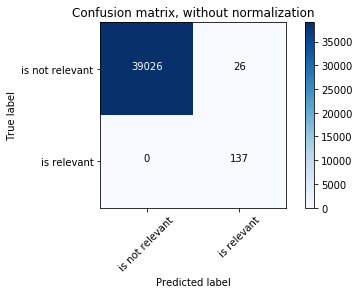

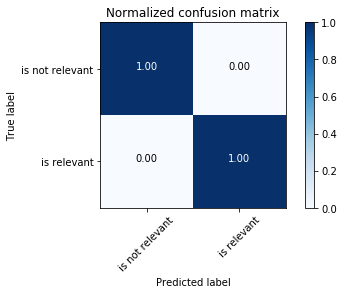

In [13]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['is not relevant', 'is relevant'],
                      title='Confusion matrix, without normalization')
plt.savefig('confusion_matrix.png')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['is not relevant', 'is relevant'], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('normalized_confusion_matrix.png')

## Model persistence

Save the model using joblib so that we can access it at some later point in time.

In [10]:
from sklearn.externals import joblib
joblib.dump(grid_search, 'model.pkl') 

['model.pkl']